In [91]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

SIR com fator de normalização.
$$\ \dot{S} = \frac{- \beta I S}{N}$$
$$\ \dot{I} = \frac{\beta I S}{N} - \gamma I$$
$$\ \dot{R} = - \gamma I S$$
com $$N = S + I + R$$
obs.: variável independente ocultada para simplificar a notação

(é um sistema de EDOs...)

In [92]:
np.random.seed(6661)

In [93]:
# 0 para 160
t = np.linspace(0, 160, 161)

beta = 0.2  # Taxa de infecção
gamma = 0.1  # Taxa de recuperação

nn_input = np.zeros((100 * (len(t) - 1), 3))
nn_output = np.zeros_like(nn_input)


def sir_deriv(s_i_r, t0, beta=beta, gamma=gamma):
    S, I, R = s_i_r
    N = S + I + R
    dS = (-beta * S * I) / N
    dI = ((beta * S * I) / N) - gamma * I
    dR = gamma * I
    return [dS, dI, dR]

# random int values between 1000 and 2000
s = np.random.randint(1000, 2000, size=100)
# random int values between 200 and 300
i = np.random.randint(100, 200, size=100)
# random int values between 0 and 100
r = np.random.randint(0, 50, size=100)
x0 = np.array([s, i, r]).T
print(x0.shape)

(100, 3)


In [94]:
x_t = np.asarray([integrate.odeint(sir_deriv, x0_j, t) for x0_j in x0])
print(x_t.shape)
x_t[0][0]

(100, 161, 3)


array([1606.,  129.,   12.])

In [95]:
for j in range(100):
    nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]
nn_input.shape

(16000, 3)

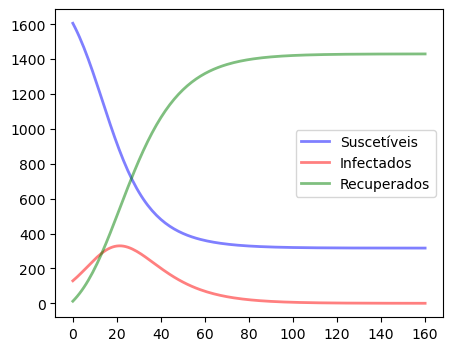

In [96]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, x_t[0, :, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, x_t[0, :, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, x_t[0, :, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
plt.legend()
plt.show()

Até aqui tudo certo. Esta é mesmo a "cara" do SIR.

In [97]:
# Normalization
#nn_input = nn_input / 1000
#nn_output = nn_output / 1000

In [98]:
print(nn_input.shape)
print(nn_output.shape)

(16000, 3)
(16000, 3)


In [99]:
net = keras.models.Sequential()
net.add(layers.Dense(10, input_dim=3, activation='sigmoid'))
net.add(layers.Dense(10, activation='relu'))
net.add(layers.Dense(3, activation='linear'))
net.compile(loss='mse', optimizer='adam')

In [100]:
History = net.fit(nn_input, nn_output, epochs=10)

Epoch 1/10
500/500 [==============================] - 1s 715us/step - loss: 595412.4375
Epoch 2/10
500/500 [==============================] - 0s 709us/step - loss: 531021.8750
Epoch 3/10
500/500 [==============================] - 0s 699us/step - loss: 425685.6875
Epoch 4/10
500/500 [==============================] - 0s 703us/step - loss: 323965.6875
Epoch 5/10
500/500 [==============================] - 0s 697us/step - loss: 240089.3438
Epoch 6/10
500/500 [==============================] - 0s 707us/step - loss: 178674.7031
Epoch 7/10
500/500 [==============================] - 0s 703us/step - loss: 136720.0312
Epoch 8/10
500/500 [==============================] - 0s 725us/step - loss: 110556.4844
Epoch 9/10
500/500 [==============================] - 0s 721us/step - loss: 94199.3125
Epoch 10/10
500/500 [==============================] - 0s 707us/step - loss: 86474.6875


In [101]:
ynn = np.zeros((1, len(t), 3))
ynn[0, 0, :] = (np.random.randint(1000, 2000), np.random.randint(100, 200), np.random.randint(0, 50))
for jj, tval in enumerate(t[:-1]):
    ynn[0, jj + 1, :] = net.predict(ynn[:, jj, :], verbose = 1)

1/1 [==============================] - 0s 14ms/step


In [102]:
y0 = ynn[0, 0, :]
y_t = integrate.odeint(sir_deriv, y0, t)

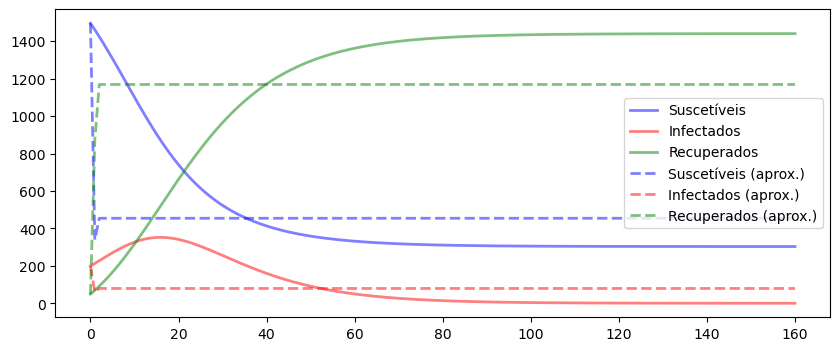

In [105]:
# plot y_t
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, y_t[:, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, y_t[:, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, y_t[:, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
# plot prediction
ax.plot(t, ynn[0, :, 0], 'b--', alpha=0.5, lw=2, label='Suscetíveis (aprox.)')
ax.plot(t, ynn[0, :, 1], 'r--', alpha=0.5, lw=2, label='Infectados (aprox.)')
ax.plot(t, ynn[0, :, 2], 'g--', alpha=0.5, lw=2, label='Recuperados (aprox.)')
plt.legend()
plt.show()